In [7]:
import numpy as np
import yaml
from lasdi.workflow import *
from lasdi.postprocess import *
import h5py

In [14]:
results_file = 'lasdi_10_23_2025_20_30.npy'
config_path = 'FAE-experiments/burgers1d-flasdi.yml'
data = np.load(results_file, allow_pickle=True).item()
for key, value in data.items():
    print(key)

# load config
with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
        cfg_parser = InputParser(config, name='main')


trainer, param_space, physics, autoencoder, latent_dynamics = initialize_trainer(config, None)
trainer = data['trainer']
latent_dynamics = data['latent_dynamics']
print(latent_dynamics)
print(data['avg_rel_err'])
autoencoder.load_state_dict(data['latent_space']['autoencoder_param'])


parameters
physics
latent_space
latent_dynamics
trainer
timestamp
result
max_rel_err
avg_rel_err
num_params
train_time
eval_time
{'dim': 5, 'ncoefs': 30, 'fd_type': 'sbp12', 'coef_norm_order': 'fro'}
Result.Unexecuted


/Users/margaret/anaconda3/envs/python3.9/lib/python3.9/site-packages/lasdi/inputs.py:37: UserWarning: <class 'str'> does not match the type with the fallback value <class 'int'>!
  warn("%s does not match the type with the fallback value %s!" % (str(type(val)), str(type(fallback))))


<All keys matched successfully>

In [3]:
print(cfg_parser)

In [9]:
# view data
data_param_path = 'sampling/new_test.burgers1d.h5'
with h5py.File(data_param_path, 'r') as f:
    # List all groups/datasets
    print("Keys:", list(f.keys()))
    parameters = f['parameters'][:]
    test_params = f['test_params'][:]

print("Parameters shape:", parameters.shape)
print("Test parameters shape:", test_params.shape)

data_X_path = 'sampling/new_Xtest.burgers1d.h5'
with h5py.File(data_X_path, 'r') as f:
    # List all groups/datasets
    print("Keys:", list(f.keys()))
    test_sol = f['test_sol'][:]
   
print("Test solution shape:", test_sol.shape)
U0_test = test_sol[:, 0:1, :]


Keys: ['parameters', 'test_params']
Parameters shape: (2,)
Test parameters shape: (441, 2)
Keys: ['test_sol']
Test solution shape: (441, 1001, 1001)


In [10]:
# Run model to predict solutions
num_params = count_params(autoencoder)
coefs = trainer['best_coefs']
X_train = trainer['X_train']
X_test = trainer['X_test']
paramspace_dict = data['parameters'] #contains 'train_space' and 'test_space'
param_train = paramspace_dict['train_space']
param_grid = paramspace_dict['test_space']
test_meshgrid = paramspace_dict['test_meshgrid']
test_grid_sizes = paramspace_dict['test_grid_sizes']
n_samples = config['lasdi']['gplasdi']['n_samples']
physics_dict = data['physics']
t_grid = physics_dict['t_grid']
x_grid = physics_dict['x_grid']
gp_dictionnary = fit_gps(param_space.train_space, coefs)
Zis_mean = average_rom(autoencoder, physics, latent_dynamics, gp_dictionnary, param_grid)
X_pred_mean = autoencoder.decoder(torch.Tensor(Zis_mean)).detach().numpy()
avg_rel_error = np.zeros(param_grid.shape[0])
for k in range(param_grid.shape[0]):
    avg_rel_error[k], _ = compute_errors(X_pred_mean[k], physics, X_test[k].numpy())
max_rel_error = avg_rel_error.max()
avg_avg_rel_error = avg_rel_error.mean()

/Users/margaret/anaconda3/envs/python3.9/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/margaret/anaconda3/envs/python3.9/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/margaret/anaconda3/envs/python3.9/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) 

In [43]:
print(avg_rel_error.shape)

(441,)


(21, 21)
(21, 21)
Mean of errors: 0.8559054279543645
Max of errors: 0.872256338596344
(20, 2)
Num_params: 3446


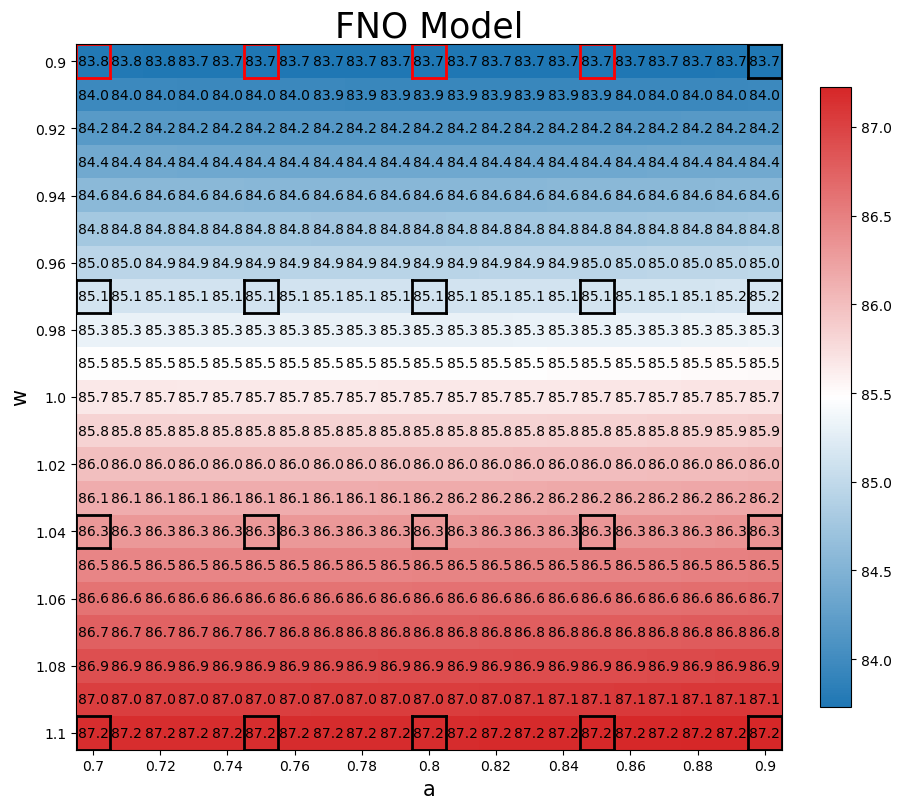

In [13]:
# Evaluate model 
data_info_yml_path = 'data_info.yml'
with open(data_info_yml_path, 'r') as f:
        data_info = yaml.safe_load(f)
a_min = data_info['a_min']
a_max = data_info['a_max']
n_a_grid = data_info['n_a_grid']
w_min = data_info['w_min']
w_max = data_info['w_max']
n_w_grid =  data_info['n_w_grid']
# create a grid for the parameter a
a_grid = np.linspace(a_min, a_max, n_a_grid)
w_grid = np.linspace(w_min, w_max, n_w_grid)
a_grid, w_grid = np.meshgrid(a_grid, w_grid, indexing='ij')

all_errors = avg_rel_error.reshape(n_a_grid, n_w_grid)
print(a_grid.shape)
print(all_errors.shape)
print("Mean of errors:", np.mean(all_errors))
print("Max of errors:", np.max(all_errors))
print(param_train.shape)
# param_train_0 to np
param_train_0 = np.array(param_train)
# substract 0.001 from every param_train 0 entry
param_train_0[:, 1] = param_train_0[:, 1] - 0.001
param_train_0[:,0] = param_train_0[:,0] - 0.001
#round param_train_0
print("Num_params:", num_params)
heatmap2d(all_errors*100,a_grid[:,0],w_grid[0],param_train_0,4,param_labels=['a','w'], title='FNO Model')

100 epochs error ranged 78-83
500 epochs error ranged 83-87. I think it's not doing what I think it's doing